In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier
from datasetprocessing import *
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import pickle
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt 
import collections

In [2]:
data = pd.read_csv("commentDataLabelled.csv", encoding = "UTF-8")
data

,Text,Label
0,@BernieSanders Thank you Bernie! Together we c...,1
1,@BernieSanders Agreed https://t.co/0Nbg0NxraG,1
2,@BernieSanders We cordially invite you to sett...,1
3,@BernieSanders Plant trees 🌳\nSave the bees 🐝\...,1
4,@BernieSanders Thy them see\nThis\n\nhttps://t...,1
...,...,...
2212,that was an asshole move and he fucking knows ...,4
2213,"RT @anthony_burch: 66,000 Afghani soldiers die...",4
2214,On the bright side: that asshole's tweet remin...,4
2215,RT @Angry_Staffer: What an asshole. \n\nHe mig...,4


We first check if the dataset is balanced. During the first trials, I noticed that there were much more critical comments(3) and neutral comments(2) than the others. Thus, afterwards I had to look for more (1) and (4) data to add to the table. 

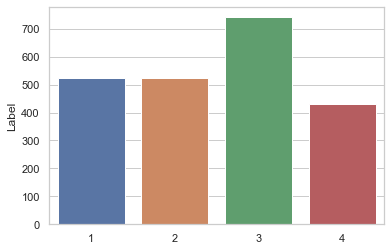

In [3]:
values = data.Label.value_counts()
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = values.index, y = values)

Text(0, 0.5, 'Number of ?')

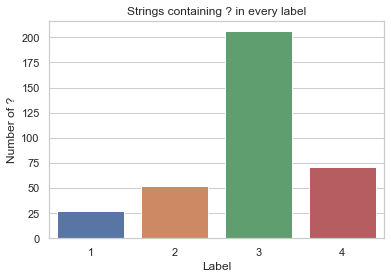

In [4]:
results = collections.defaultdict(int)
for i, row in data.iterrows():
    if '?' in row['Text']:
        results[row['Label']] += 1
keys = [key for key in results]
values = list(results.values())
ax = sns.barplot(x = keys, y = values)
plt.title('Strings containing ? in every label')
plt.xlabel('Label')
plt.ylabel('Number of ?')

Text(0, 0.5, 'Number of !')

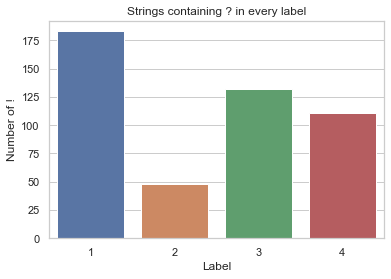

In [5]:
results = collections.defaultdict(int)
for i, row in data.iterrows():
    if '!' in row['Text']:
        results[row['Label']] += 1
keys = [key for key in results]
values = list(results.values())
ax = sns.barplot(x = keys, y = values)
plt.title('Strings containing ? in every label')
plt.xlabel('Label')
plt.ylabel('Number of !')

Using the process_text function in datasetprocessing.py, we can perform some preprocessing of the data text field. 
1. All @user patterns are removed from the text string. Ex. (@Angry_Staffer, @teslaqovsky)
2. All links are removed from the text string. 
3. Miscellaneous strings that provide no value are removed. Ex. (&amp; , RT)
4. All text becomes lower case with punctuation removed.
5. Text is lemmatized using the textblob library.

In [6]:
data = process_dataset(data)

Seeing that '?' appears more commonly in label 3 and 4, I created a new feature that looks at if the text contains a question mark. The same thing is done for exclamation marks. I then split the label from the dataset to prepare for training.

In [7]:
data['Label'] = data['Label'] - 1
data['Text'] = data.apply(lambda row : process_text(row['Text']),axis = 1)
labels = data.Label
data = data.drop(columns=["Label"])

We will use a few baseline classifiers to make predictions. The data is split into training and test datasets and tokenized with the TfidfVectorizer.

In [8]:
classifiers = [XGBClassifier(use_label_encoder=False,eval_metric='logloss'), svm.SVC(kernel='rbf',C=100), MultinomialNB(alpha=0.1), LogisticRegression(penalty = 'l2', C=0.1)]
results = collections.defaultdict(float)


In [15]:
def train(classifiers, output = False):
    x_train,x_test,y_train,y_test = train_test_split(data[['Text','Question','Exclamation','Upper Case']], labels, test_size = 0.2)
    tfidf_vectorizer = TfidfVectorizer(stop_words="english",max_df = 0.5)
    tfidf_train = tfidf_vectorizer.fit_transform(x_train['Text'])
    tfidf_test = tfidf_vectorizer.transform(x_test['Text'])
    train_1 = np.swapaxes([x_train['Question'].to_numpy()],0,1)
    train_2 = np.swapaxes([x_train['Upper Case'].to_numpy()],0,1)
    train_3 = np.swapaxes([x_train['Exclamation'].to_numpy()],0,1)
    test_1 = np.swapaxes([x_test['Question'].to_numpy()],0,1)
    test_2 = np.swapaxes([x_test['Upper Case'].to_numpy()],0,1)
    test_3 = np.swapaxes([x_test['Exclamation'].to_numpy()],0,1)

    tfidf_train = sp.sparse.hstack((tfidf_train,train_1, train_2,train_3))
    tfidf_test = sp.sparse.hstack((tfidf_test,test_1, test_2,test_3))


    for classifier in classifiers:
        clf, score = benchmark(classifier,tfidf_train,tfidf_test,y_train,y_test, x_test, output)
        results[clf] += score

In [16]:
def benchmark(clf, x_train, x_test, y_train, y_test, test,display = False):
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    
    score = metrics.accuracy_score(y_test, pred)
    if display:
        confusion_mtx(y_test, pred)
        for input, prediction, label in zip(test['Text'], pred, y_test):
            if prediction != label:
                print(input, 'has been classified as ', prediction, 'and should be ', label) 

    clf_descr = str(clf).split('(')[0]
    return clf_descr, score

In [19]:
def confusion_mtx(actual, pred):
    cm = confusion_matrix(actual, pred)
    cm_df = pd.DataFrame(cm, index = ['0','1','2','3'],columns = ['0','1','2','3'])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.savefig('confusion_matrix.png')

In [21]:
n_trials = 20
results = collections.defaultdict(float)
for i in range(n_trials):
    train(classifiers)
for key in results:
    results[key] = results[key] / n_trials
results


defaultdict(float,
            {'XGBClassifier': 0.571283783783784,
             'SVC': 0.5680180180180181,
             'MultinomialNB': 0.5547297297297296,
             'LogisticRegression': 0.4658783783783784})

Using the XGB Classifier, I created a confusion matrix as well as a list of all the incorrectly predicted entries.

endproxywar stoptaliban stopterrorism saveafghanistan sanctionsonpakistan pakproxywarafg securitycouncil shutdowndohaoffice joebiden vladimir_putin antonioguterres khalilzad_is_traitor attention_americans has been classified as  1 and should be  3
cool now do trump has been classified as  1 and should be  2
student justice league will not stop helping vulnerable incarcerated people during this global health emergency learn more at http t.co/qhmohw69fq theinnocencefiles secondchancemonth decarceratenow freeouryouth endlifeimprisonment has been classified as  1 and should be  2
oh and in case we have n't said it lately you 're all fucking rock star releasetheayercut has been classified as  3 and should be  0
how many do you have has been classified as  2 and should be  1
gave conservative the finger has been classified as  0 and should be  1
 has been classified as  1 and should be  3
want to play for your team has been classified as  1 and should be  0
nothing the generation in power wi

🇨🇦 here always thought it ironic that america say it ’ s big on family value when they seem to do so little to… has been classified as  3 and should be  2
glimmer of hope neighbor long time voted trump 2016 but not 2020 is appalled by insurrection outraged over response when fundraiser called she let them have it said no support till they get their house in order voteblue22 vote has been classified as  2 and should be  0
beyond grateful to be back and with you 🙏🏽 has been classified as  1 and should be  0
nobody need you go back to flying on private jet has been classified as  2 and should be  3
this is what fauci said in march has been classified as  0 and should be  2
bitcoin is not about country corporation bank or big tech it 's about regular people sending receiving money and doin… has been classified as  2 and should be  1
talk to your good friend biden about stopping all the drilling pipeline and fracking start there today has been classified as  3 and should be  2
too fucking l

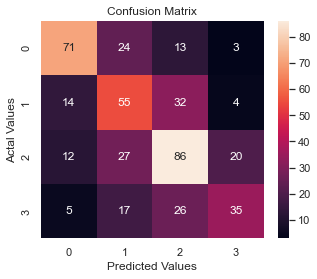

In [20]:
train([XGBClassifier(use_label_encoder=False,eval_metric='logloss')], output = True)

From the confusion matrix, label 0 seems to be the most accurately predicted. The right values are predicted most of the time but there is a lot of confusion especially with labels 1 and 2. For example, "america offer" has been classified as 2(Critical) vs the ground truth of 1(Neutral). I think that this is due to many critical(2) tweets having the word america in it. 

One idea is to try n-grams of words. For example, considering the bi-grams of the sentence "feel like we" we have: "feel","like","we","feel like","like we". This can hopefully capture more context of the sentence. 

In [23]:
def train(classifiers, output = False):
    x_train,x_test,y_train,y_test = train_test_split(data[['Text','Question','Exclamation','Upper Case']], labels, test_size = 0.2)
    tfidf_vectorizer = TfidfVectorizer(stop_words="english",max_df = 0.5, ngram_range=(1,2))
    tfidf_train = tfidf_vectorizer.fit_transform(x_train['Text'])
    tfidf_test = tfidf_vectorizer.transform(x_test['Text'])
    train_1 = np.swapaxes([x_train['Question'].to_numpy()],0,1)
    train_2 = np.swapaxes([x_train['Upper Case'].to_numpy()],0,1)
    train_3 = np.swapaxes([x_train['Exclamation'].to_numpy()],0,1)
    test_1 = np.swapaxes([x_test['Question'].to_numpy()],0,1)
    test_2 = np.swapaxes([x_test['Upper Case'].to_numpy()],0,1)
    test_3 = np.swapaxes([x_test['Exclamation'].to_numpy()],0,1)

    tfidf_train = sp.sparse.hstack((tfidf_train,train_1, train_2,train_3))
    tfidf_test = sp.sparse.hstack((tfidf_test,test_1, test_2,test_3))


    for classifier in classifiers:
        clf, score = benchmark(classifier,tfidf_train,tfidf_test,y_train,y_test, x_test, output)
        results[clf] += score

In [24]:
n_trials = 20
results = collections.defaultdict(float)
for i in range(n_trials):
    train(classifiers)
for key in results:
    results[key] = results[key] / n_trials
results


defaultdict(float,
            {'XGBClassifier': 0.5684684684684684,
             'SVC': 0.5594594594594594,
             'MultinomialNB': 0.5543918918918919,
             'LogisticRegression': 0.436036036036036})

Unfortunately, bi-grams did not provide better results. I think this is due to there being not enough data. Specific patterns of words do not come up frequently enough for the machine to make meaningful classifications. 

As well, we drop logistic regression from the baseline as it consistenly provides worse results. We will try using GridSearch to find the best hyperparameters for these models. 

In [37]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english",max_df = 0.5)
tfidf_data = tfidf_vectorizer.fit_transform(data['Text'])
train_1 = np.swapaxes([data['Question'].to_numpy()],0,1)
train_2 = np.swapaxes([data['Upper Case'].to_numpy()],0,1)
train_3 = np.swapaxes([data['Exclamation'].to_numpy()],0,1)
tfidf_data = sp.sparse.hstack((tfidf_data,train_1, train_2,train_3))



In [38]:
svc_params = {'C': [1, 10, 50, 100], 'kernel': ['linear']}, {'C': [10, 100, 500, 1000], 'gamma': [0.0001], 'kernel': ['rbf']}
svc = svm.SVC()
clf = GridSearchCV(svc, svc_params)
clf.fit(tfidf_data, labels)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in sorted(zip(means, stds, clf.cv_results_['params']), key=lambda x: -x[0]):
    print("Accuracy: %0.3f (+/-%0.03f) for params: %r" % (mean, std * 2, params))

Accuracy: 0.525 (+/-0.079) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.504 (+/-0.069) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.465 (+/-0.066) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.455 (+/-0.069) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.419 (+/-0.038) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.379 (+/-0.026) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.348 (+/-0.016) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.334 (+/-0.001) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


In [42]:
xgb_params = {
    'max_depth': range (2, 8, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
xgb = XGBClassifier(use_label_encoder=False,eval_metric='logloss')
clf = GridSearchCV(xgb, xgb_params)
clf.fit(tfidf_data, labels)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in sorted(zip(means, stds, clf.cv_results_['params']), key=lambda x: -x[0]):
    print("Accuracy: %0.3f (+/-%0.03f) for params: %r" % (mean, std * 2, params))

Accuracy: 0.494 (+/-0.086) for params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 140}
Accuracy: 0.493 (+/-0.072) for params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 180}
Accuracy: 0.492 (+/-0.086) for params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 180}
Accuracy: 0.492 (+/-0.078) for params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 180}
Accuracy: 0.491 (+/-0.085) for params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Accuracy: 0.491 (+/-0.085) for params: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 180}
Accuracy: 0.489 (+/-0.093) for params: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 140}
Accuracy: 0.489 (+/-0.077) for params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 140}
Accuracy: 0.489 (+/-0.103) for params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 140}
Accuracy: 0.488 (+/-0.088) for params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 180}
Accurac

In [43]:
classifiers = [XGBClassifier(use_label_encoder=False,eval_metric='logloss', learning_rate = 0.1, n_estimators = 140, max_depth = 6), 
               svm.SVC(kernel='linear',C=1), MultinomialNB(alpha=0.1)]
n_trials = 20
results = collections.defaultdict(float)
for i in range(n_trials):
    train(classifiers)
for key in results:
    results[key] = results[key] / n_trials
results

defaultdict(float,
            {'XGBClassifier': 0.5594594594594594,
             'SVC': 0.5882882882882882,
             'MultinomialNB': 0.5551801801801803})

Looks like SVC had a lot of improvements from parameter tuning. 